# PROJECT 2 : TEAM 11

Members: Talia Tandler, SeungU Lyu

In [88]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import math

http://www.worldometers.info/world-population/us-population/
US pop in 2017 = 324,459,463

https://wwwnc.cdc.gov/travel/yellowbook/2018/infectious-diseases-related-to-travel/measles-rubeola
Measles incubation period 11 days average, infectious period 2-4 days before rash to after rash.

In [89]:
pop = 999  #population
init_im = 0.85    #initial immunity of the US population
beta = 0.9        #assumed contact rate
gamma = 1/7      #US recovery rate from measles
sigma = 0.091     #US rate from exposure period of 11 days to infected

0.091

## Question

### What is the result of lowering the measles immunity rate in a small community during a outbreak?

Measles is a highly infectious disease that can infect about 90% of people that come into contact with the patient. However, the disease is not common these days because of the MMR vaccination, which can effectively prevent people getting the disease. Due to the high vaccination rate, the United States was declared free of circulating measles in 2000. However there were 911 cases of measles between 2001 and 2011. These occurences arose due to individuals from other countries entering the U.S. with measles. Because of the disease's high infectious rate upon contact, herd immunity is considered very important for measles. 

In 2015, a measles outbreak occured at Disney World causing more than 159 people to be infected during a single outbreak. Only 50~86% people exposed to this outbreak were vaccinated, causing an even bigger outbreak. This vaccination was lower than it should have been due to Anti-Vaccination Movements in the U.S. These lower rates lowered the population immunity rate and caused the herd immunity to not function as expected. The starter of this movement, Andrew Wakefield, stated that the MMR vaccination can cause autism in newborn children because of the mercury content inside the specific vaccine. Due to this false research, many parents became concerned with the side effects of the vaccination and opted to not vaccinate their children with MMR. As a result, there was a decently sized generation of children susceptible to measles because they did not receive the vaccination at birth.

This simulation utilizes an SEIR model to understand how varying the measles immunity rate in a community effects herd immunity.

## Methodology

In order to create this model, we:

1. Did background research on the MMR vaccination and the measles diseases and found a set of constants we would implement in our model.
2. Put the variables into a state function.
3. Set the total population to 1000, with initial infection number as one person infected with measles.
4. Ran the simulation based on the number measles infections every day.
5. Set a condition where the measles outbreak ends when the number infected people is less than one person. 
6. Created graphs to visually represent our results.

In [90]:
def make_system (pop, init_im, beta, gamma, sigma):
    """Make a system object for the SCIR model
    
    pop: Total US population
    init_im: Initial Population Immunity
    gamm: recovery rate for infected people
    sigma: rate of incubation group moving to infectious group
    return: System object"""
    
    init = State(S = int(pop*(1 - init_im)), E = 0, I = 1, R = int(pop*init_im))
    init /= np.sum(init)
    #S: susceptible, E: exposed period, I: infected, R: recovered(immune to disease)
    
    t0 = 0
    t_end = 365 #number of days in 1 year
    
    return System(init = init,
                  beta = beta,
                  gamma = gamma,
                  sigma = sigma,
                  t0 = t0,
                  t_end = t_end,
                  init_im = init_im)

In [91]:
def update_func(state, time, system):
    """Update the SEIR model
    
    state: starting variables of SEIR
    t: time step
    system: includes alpha,beta,gamma,omega rates
    contact: current contact number for the state
    
    """
    
    unpack(system)
    
    s,e,i,r = state
    
#    if time>30 and i<0.001:
#        e = 0
#        i = 0
            
    #current population
    total_pop = s+e+i+r
    
    #change rate for each status
    ds = (-beta*s*i)/total_pop #change in number of people susceptible
    de = ((beta*s*i)/total_pop) - sigma*e #change in number of people moving to exposed period
    di = sigma*e - gamma*i     #change in people moving to infectious period
    dr = gamma*i     #change in people recovered

    s += ds      #number of people susceptible
    e += de      #number of people exposed
    i += di      #number of people infected
    r += dr      #number of people recovered
    
    return State(S=s, E=e, I=i, R=r)

In [92]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)
    
    #creates timeframe to save daily states
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
    
    for time in linrange(t0, t_end):
        frame.row[time+1] = update_func(frame.row[time], time, system)
    
    return frame

In [93]:
def plot_results (S,E,I,R):
    
    plot(S, '--', label = 'Susceptible')
    plot(E, '-', label = 'Exposed')
    plot(I, '.', label = 'Infected')
    plot(R, ':', label = 'Recovered')
    decorate(xlabel='Time (days)',
            ylabel = 'Fraction of population')

In [94]:
init_im = 0.907
system = make_system(pop, init_im, beta, gamma, sigma)
results = run_simulation(system, update_func)
results;
#plot(results.I)

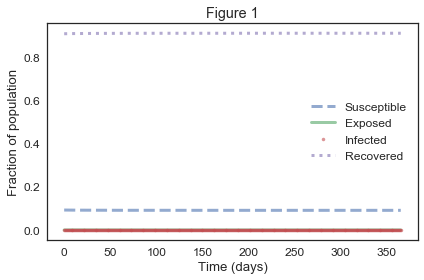

In [95]:
plot_results(results.S, results.E, results.I, results.R)
decorate(title ='Figure 1')

In [96]:
init_im2 = 0.3
system = make_system(pop, init_im2, beta, gamma, sigma)
results2 = run_simulation(system, update_func)
results2;

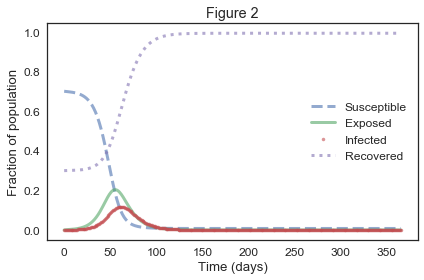

In [97]:
plot_results(results2.S, results2.E, results2.I, results2.R)
decorate (title = 'Figure 2')

In [98]:
def calc_highest_infected(results):
    """Fraction of population infected during the simulation.
    
    results: DataFrame with columns S, I, R
    
    returns: fraction of population
    """
    return max(results.I)

In [99]:
def calc_fraction_infected(results):

    return (get_first_value(results.S) - get_last_value(results.S))/get_first_value(results.S)

In [100]:
def sweep_init_im(imun_rate_array):
    """Sweep a range of values for beta.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    sweep = SweepSeries()
    for init_im in imun_rate_array:
        system = make_system(pop, init_im, beta, gamma, sigma)
        results = run_simulation(system, update_func)
        sweep[system.init_im] = calc_highest_infected(results)*pop
    return sweep

In [101]:
def sweep_init_im2(imun_rate_array):
    """Sweep a range of values for beta.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    sweep = SweepSeries()
    for init_im in imun_rate_array:
        system = make_system(pop, init_im, beta, gamma, sigma)
        results = run_simulation(system, update_func)
        sweep[system.init_im] = calc_fraction_infected(results)*100
    return sweep

In [102]:
imun_rate_array = linspace(0, 1, 11)
sweep = sweep_init_im(imun_rate_array) 
sweep

,values
0.0,208.313630
0.1,177.918762
0.2,147.602195
0.3,117.985077
0.4,89.378869
0.5,62.132854
0.6,37.160085
0.7,15.994027
0.8,2.115958
0.9,1.000000


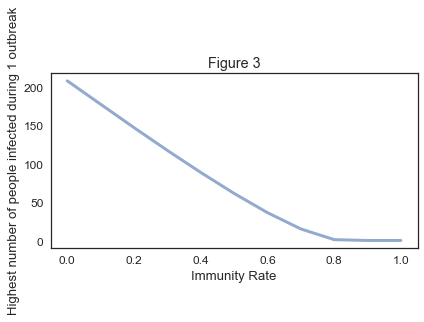

In [103]:
plot(sweep)
decorate(xlabel='Immunity Rate',
        ylabel = 'Highest number of people infected during 1 outbreak',
        title = 'Figure 3')

In [104]:
imun_rate_array = linspace(0, 1, 21)
sweep2 = sweep_init_im2(imun_rate_array) 
sweep2

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


,values
0.00,99.880178
0.05,99.827227
0.10,99.749787
0.15,99.638624
0.20,99.479228
0.25,99.250722
0.30,98.922845
0.35,98.451307
0.40,97.770428
0.45,96.781122


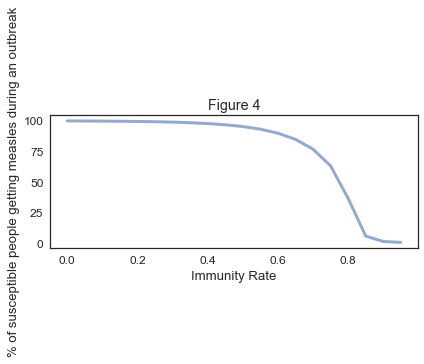

In [105]:
plot(sweep2)
decorate(xlabel='Immunity Rate',
        ylabel = '% of susceptible people getting measles during an outbreak',
        title = 'Figure 4')

## Results

This model uses SEIR methodology to examine how measels would spread throughout a community of 1000 individuals with varying immunity rates. Figure 1 depicts an SEIR representation based on a 85% measles immunity rate, equivalent to that of the immunity rate in the United States. Due to the high herd immunity rate, the number of individuals in each of the categories, susceptible, recovered, and infected remains constant throughout the simulated outbreak.

Figure 2 represents an example of the SEIR model with an immunity rate of 30%. In this model, we can see that as the number of susceptible individuals decreases, the number of recovered individuals increases at an equal and opposite rate. The entire population is recovered from this measles outbreak within 150 days of the start.

Figure 3 depicts the predicted outcome of this model that as the immunity rate in a community increases, the number of people infected during an outbreak will decrease. We see the number of infected individuals plateau around 80% immunity.

Figure 4 depicts the percent of susceptible individuals that do contract measles during an outbreak. At low immunity rates (without herd immunity) a large percent of susceptible individuals do contract measles. As the immunity rate increases, this percentage decreases.

## Interpretation

As expected, as the immunity rate in the community increased, the highest number of people infected with measles during an outbreak decreased. The number of people infected with measles begins to plateau between an 80 - 85% immunity rate. From the data that Figure 4 is based on we can see that the ideal immunity rate for a community is between 80 - 85%. Between these 2 numbers, the percent of susceptible individuals that contract measles drops sharply from 36% to 6%. Our initial immunity rate in this community was 85%, so this does align with what was predicted in the model.

Our model does have several limitations:
1. We were unable to find an effective contact number or contact rate for measles within the United States. Having this number would have enabled us to calculate beta instead of just assuming it to be 90%.

2. The model gets to a point where less than 1 person is infected with measles. This is physically impossible as you cannot have less than one person. In our results, we interpreted less than 1 to mean the individual did not have measles. 

## Abstract

In this model, we were seeking to find out the result of lowering the measles immunity rate in a small community during a outbreak. As predicted, we found that as the immunity rate in a community is lowered, the number of infections in a community increases. We also found that when immunity is between 80-85%, the number of individuals infected in a population begins to plateau. This finding indicated that the ideal immunity rate for a community of 1000 individuals is between 80-85%.
